In [17]:
# install for data
!pip install -U finance_datareader

In [18]:
from datetime import datetime
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [21]:
df_kospi = fdr.StockListing('KOSPI')
df_kospi.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
6,152100,KOSPI,ARIRANG 200,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7,295820,KOSPI,ARIRANG 200동일가중,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8,253150,KOSPI,ARIRANG 200선물레버리지,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [57]:
df_kospi[df_kospi['Name'] == '삼성전자']['Symbol'].values[0]

'005930'

In [58]:
import FinanceDataReader as fdr
def get_data(name, pos, start, end):
    pos_df = fdr.StockListing(pos)
    code = pos_df[pos_df['Name'] == name]['Symbol'].values[0]

    return fdr.DataReader(code, start, end)


start = datetime(2017,11,1)
end = datetime(2021,11,1)
stock_df = get_data('삼성전자', 'KOSPI', start, end)
stock_df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-11-01,57500,57500,56179,57220,290205,0.038853
2017-11-02,57500,57519,56760,57060,214421,-0.002796
2017-11-03,57059,57140,55860,56380,198716,-0.011917
2017-11-06,56380,56500,55340,56380,180019,0.000000
2017-11-07,56380,56920,55860,56100,149291,-0.004966


In [59]:
stock_df.shape

(984, 6)

In [60]:
stock_df.describe()

,Open,High,Low,Close,Volume,Change
count,984.000000,984.000000,984.000000,984.000000,9.840000e+02,984.000000
mean,56433.370935,56987.666667,55857.752033,56562.428862,1.429856e+07,0.000385
std,14077.294991,14185.102713,13990.302229,13707.430361,1.010825e+07,0.016924
min,0.000000,0.000000,0.000000,37450.000000,0.000000e+00,-0.063877
25%,46400.000000,46800.000000,45900.000000,46300.000000,8.467427e+06,-0.009898
50%,51010.000000,51630.000000,50550.000000,51200.000000,1.293404e+07,0.000000
75%,61100.000000,61525.000000,60525.000000,61025.000000,1.854970e+07,0.009938
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.104706


## 2. 데이터 전처리

### 2.1. 다양한 입력피쳐 설계하기

#### 2.1.1 중간값

In [62]:
high_prices = stock_df['High'].values
low_prices = stock_df['Low'].values
mid_prices = (high_prices + low_prices) / 2
stock_df['Mid'] = mid_prices

#### 2.1.2 이동평균

In [64]:
#MA5, MA20
ma5 = stock_df['Change'].rolling(window=5).mean()
stock_df['MA5'] = ma5

ma20 = stock_df['Change'].rolling(window=20).mean()
stock_df['MA20'] = ma20

stock_df = stock_df.fillna(0)

#### 2.1.3 거래량이동평균

In [65]:
#거래량이동평균- VMA5
vma5 = stock_df['Volume'].rolling(window=5).mean()
stock_df.insert(len(stock_df.columns), "VMA5", vma5)
stock_df = stock_df.fillna(0)

#### 2.1.4 이격도

In [67]:
disp5 = (stock_df['Change']/stock_df['MA5'])*100
disp5 = disp5.replace([np.inf, -np.inf], np.nan).fillna(0)
#MA5가 0인 2017-01-02 ~ 2017-01-04 구간에서는 이격도가 inf로 계산되므로 NaN으로 대체하여 0으로 모두 치환시킴

stock_df.insert(len(stock_df.columns), "DISP5", disp5)
stock_df

,Open,High,Low,Close,Volume,Change,Mid,MA5,MA20,VMA5,DISP5
Date,,,,,,,,,,,
2017-11-01,57500,57500,56179,57220,290205,0.038853,56839.5,0.000000,0.000000,0.0,0.000000
2017-11-02,57500,57519,56760,57060,214421,-0.002796,57139.5,0.000000,0.000000,0.0,0.000000
2017-11-03,57059,57140,55860,56380,198716,-0.011917,56500.0,0.000000,0.000000,0.0,0.000000
2017-11-06,56380,56500,55340,56380,180019,0.000000,55920.0,0.000000,0.000000,0.0,0.000000
2017-11-07,56380,56920,55860,56100,149291,-0.004966,56390.0,0.003835,0.000000,206530.4,-129.514394
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26,70600,71500,70400,71100,10528252,0.012821,70950.0,0.001431,-0.004096,9999210.6,895.682549
2021-10-27,71000,71000,70000,70100,10295316,-0.014065,70500.0,-0.000532,-0.005058,10027946.2,2645.166019
2021-10-28,69500,72200,69500,70700,20644902,0.008559,70850.0,0.001465,-0.003729,11978707.8,584.396589


#### 2.1.5 골든크로스 / 데드크로스 

In [68]:
gc_point = []
dc_point =[]

for i in range(len(stock_df['MA5'])):
    gc_point.append(False)
    dc_point.append(False)

index = 0 
for i in range(len(stock_df['MA5'])-1):
    if index < 20 :  
        pass
    #오늘 5일 단기선이 20일 장기선이 보다 작거나 같고, 내일 5일선이 상향돌파
    elif stock_df['MA5'][i] <= stock_df['MA20'][i] and stock_df['MA5'][i+1] > stock_df['MA20'][i+1]:
        gc_point[index]= True
    #오늘 5일 단기선이 20일 장기선보다 크거나 같고, 내일 5일선이 상향돌파
    elif stock_df['MA5'][i] >= stock_df['MA20'][i] and stock_df['MA5'][i+1] < stock_df['MA20'][i+1]:
        dc_point[index]= True
    index += 1
    
stock_df.insert(len(stock_df.columns), "GC", gc_point)
stock_df.insert(len(stock_df.columns), "DC", dc_point)

#### 2.1.6. RSI

In [69]:
#가격의 상승압력과 하락압력 사이의 상대적인 강도를 나타내는 지표
#1에 수렴할수록 주가의 상승추세가 크며, 0에 수렴할수록 주가의 하락추세가 크다는 것을 의미함 
tempdf = stock_df
date_index = stock_df.index.astype('str')

tempdf['tomorrow Close'] = tempdf['Close'].shift(-1)
tempdf['Fluctuation'] = tempdf['tomorrow Close'] - tempdf['Close']
U = np.where(tempdf['Fluctuation']>0, tempdf['Fluctuation'], 0)
D = np.where(tempdf['Fluctuation']<0, tempdf['Fluctuation']*(-1), 0)
AU = pd.DataFrame(U, index=date_index).rolling(window=15).mean()
AD = pd.DataFrame(D, index=date_index).rolling(window=15).mean()
RSI = AU / (AD+AU)

In [70]:
stock_df.insert(len(stock_df.columns), "RSI", RSI)
stock_df = stock_df.fillna(0)
stock_df.drop(['tomorrow Close', 'Fluctuation'], axis='columns', inplace=True)
stock_df

,Open,High,Low,Close,Volume,Change,Mid,MA5,MA20,VMA5,DISP5,GC,DC,RSI
Date,,,,,,,,,,,,,,
2017-11-01,57500,57500,56179,57220,290205,0.038853,56839.5,0.000000,0.000000,0.0,0.000000,False,False,0.000000
2017-11-02,57500,57519,56760,57060,214421,-0.002796,57139.5,0.000000,0.000000,0.0,0.000000,False,False,0.000000
2017-11-03,57059,57140,55860,56380,198716,-0.011917,56500.0,0.000000,0.000000,0.0,0.000000,False,False,0.000000
2017-11-06,56380,56500,55340,56380,180019,0.000000,55920.0,0.000000,0.000000,0.0,0.000000,False,False,0.000000
2017-11-07,56380,56920,55860,56100,149291,-0.004966,56390.0,0.003835,0.000000,206530.4,-129.514394,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26,70600,71500,70400,71100,10528252,0.012821,70950.0,0.001431,-0.004096,9999210.6,895.682549,False,False,0.376471
2021-10-27,71000,71000,70000,70100,10295316,-0.014065,70500.0,-0.000532,-0.005058,10027946.2,2645.166019,False,False,0.463415
2021-10-28,69500,72200,69500,70700,20644902,0.008559,70850.0,0.001465,-0.003729,11978707.8,584.396589,False,False,0.397727


In [71]:
#### 2.1.7. MACD

In [72]:
#단기이동평균선과 장기이동평균 사이의 관계를 보여주는 지표로, 국내 주식시장을 고려해 MA5와 MA20의 차를 이용함 
stock_df['MACD'] = stock_df['MA5'] - stock_df['MA20']
stock_df['MACDS'] = stock_df['MACD'].rolling(window=9).mean()
stock_df['Oscillator'] = stock_df['MACD'] - stock_df['MACDS']

stock_df = stock_df.fillna(0)
stock_df

,Open,High,Low,Close,Volume,Change,Mid,MA5,MA20,VMA5,DISP5,GC,DC,RSI,MACD,MACDS,Oscillator
Date,,,,,,,,,,,,,,,,,
2017-11-01,57500,57500,56179,57220,290205,0.038853,56839.5,0.000000,0.000000,0.0,0.000000,False,False,0.000000,0.000000,0.000000,0.000000
2017-11-02,57500,57519,56760,57060,214421,-0.002796,57139.5,0.000000,0.000000,0.0,0.000000,False,False,0.000000,0.000000,0.000000,0.000000
2017-11-03,57059,57140,55860,56380,198716,-0.011917,56500.0,0.000000,0.000000,0.0,0.000000,False,False,0.000000,0.000000,0.000000,0.000000
2017-11-06,56380,56500,55340,56380,180019,0.000000,55920.0,0.000000,0.000000,0.0,0.000000,False,False,0.000000,0.000000,0.000000,0.000000
2017-11-07,56380,56920,55860,56100,149291,-0.004966,56390.0,0.003835,0.000000,206530.4,-129.514394,False,False,0.000000,0.003835,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26,70600,71500,70400,71100,10528252,0.012821,70950.0,0.001431,-0.004096,9999210.6,895.682549,False,False,0.376471,0.005527,0.004227,0.001300
2021-10-27,71000,71000,70000,70100,10295316,-0.014065,70500.0,-0.000532,-0.005058,10027946.2,2645.166019,False,False,0.463415,0.004526,0.004872,-0.000346
2021-10-28,69500,72200,69500,70700,20644902,0.008559,70850.0,0.001465,-0.003729,11978707.8,584.396589,False,False,0.397727,0.005193,0.005516,-0.000323


In [73]:
### 2.2. 시각화를 통해 탐색적 데이터 분석 진행하기

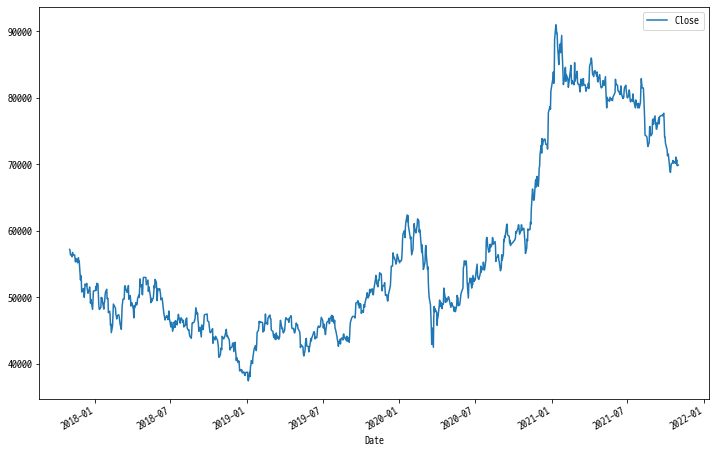

In [74]:
plt.figure(figsize=(12,8))
stock_df['Close'].plot()
plt.legend(loc='best')

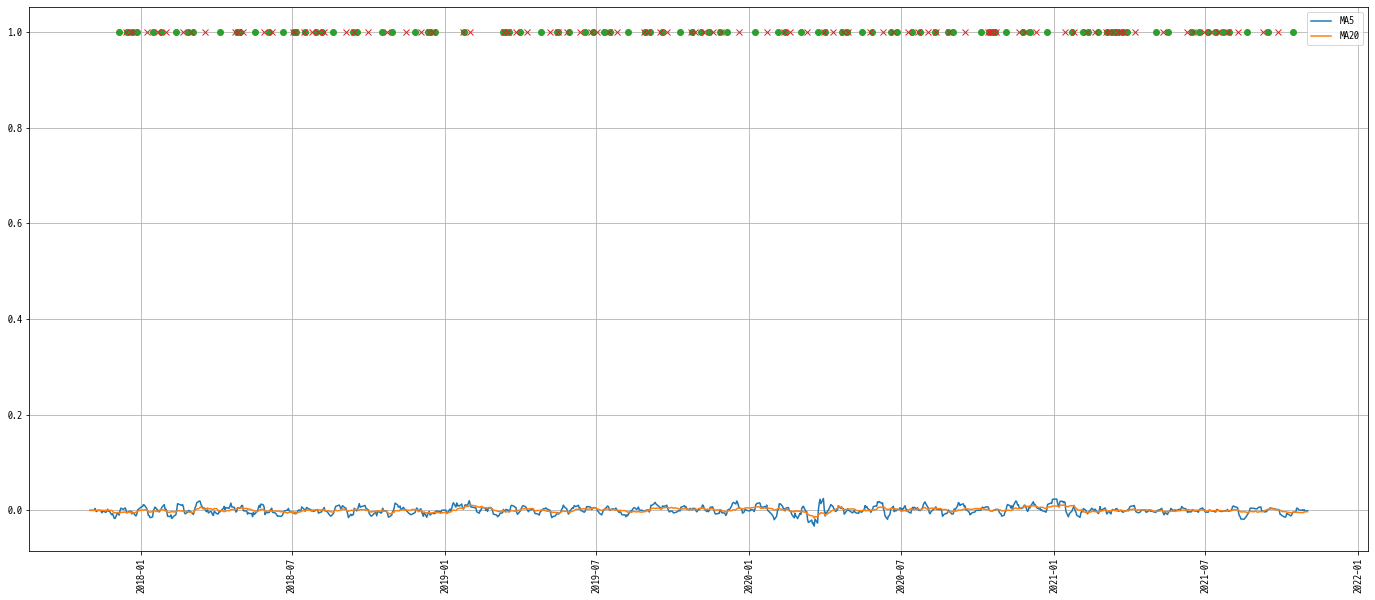

In [75]:
plt.figure(figsize=(24,10))
#plt.plot(stock_df.index, stock_df['Adj Close'], label='Adj Close')
plt.plot(stock_df.index, stock_df['MA5'], label='MA5')
plt.plot(stock_df.index, stock_df['MA20'], label='MA20')
plt.plot(stock_df['GC'].iloc[stock_df['GC'].values == True],'o')
plt.plot(stock_df['DC'].iloc[stock_df['DC'].values == True],'x')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid()
plt.show()